This work presents a specialized data preprocessing and transformation framework applied to the Autism Screening Adult dataset, specifically designed to support both geometric and probabilistic modeling. The analysis moves from raw data ingestion to a dual-branch pipeline that handles missing data via statistical imputation and transforms continuous features, such as AGE and AQ10_TOTAL_SCORE, into optimal quantile-based bins. These transformations are validated through density comparisons and correlation matrices, ensuring that the predictive signals for ASD_TARGET remain robust for Bayesian structural learning. Ultimately, this comprehensive preparation establishes the foundational layer for accurate probabilistic inference and causal risk assessment.

## Index

- [1. Data Upload](#sec1)
- [2. Dataset Transformation Table](#sec2)
  - [2.1 Dataset Variable Transformations – Geometric Models](#sec21)
  - [2.2 Dataset Variable Bayesian Network-Specific Transformations](#sec22)
- [3. Preparing the Data Set and Variables](#sec3)
  - [3.1 Removal of Non-Relevant Variables](#sec31)
  - [3.2 Handling Missing Data](#sec32)
- [4. Transformations](#sec4)
  - [4.1 Geometric models branch](#sec41)
  - [4.2 Bayesian Network branch](#sec42)
- [5. Dataset Transformation](#sec5)
  - [5.1 Transformation Geometric models branch](#sec51)
  - [5.2 Transformation Bayesian Network branch](#sec52)
  - [5.3 Downloads .CSV y Pipeline](#sec53)
- [6. Correlation analysis](#sec6)
  - [6.1 Comparation](#sec61)
  - [6.2 Results](#sec62)
- [7. Conclusions](#sec7)

## <span id="sec1"></span> **1. Data Upload**

The dataset “Autism Screening Adult”, obtained from the UCI Machine Learning Repository [Autism Screening Adult](https://archive.ics.uci.edu/dataset/426/autism+screening+adult), was used. The file was downloaded in .arff format and subsequently loaded into a DataFrame for analysis, with column names updated for better compression.

In [1]:
# Necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import seaborn as sns

from scipy.io import arff
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer

In [2]:
data, meta = arff.loadarff("../_attachments/datasets/Autism-Adult-Data.arff")
df = pd.DataFrame(data)
df = df.apply(
    lambda col: col.map(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
)

df.columns = [
    'FINE_DETAILS_AQ_1', 'GLOBAL_FOCUS_AQ_2', 'FOLLOW_CONVERSATIONS_AQ_3', 'TASK_SWITCHING_AQ_4', 'UNDERSTAND_INTENTIONS_AQ_5', 'NOTICE_INTEREST_AQ_6', 'SOCIAL_IMAGINATION_AQ_7',
    'INTENSE_INTERESTS_AQ_8', 'READ_FACIAL_EXPRESSIONS_AQ_9', 'SOCIAL_FRIENDSHIP_AQ_10', 'AGE', 'GENDER', 'ETHNICITY', 'JAUNDICE', 'AUTISM_FAMILY_HISTORY', 'COUNTRY_OF_RESIDENCE',
    'USED_APP_BEFORE', 'AQ10_TOTAL_SCORE', 'AGE_RANGE', 'RELATION', 'ASD_TARGET'
]
target = 'ASD_TARGET'
print("Dataset loaded successfully")

Dataset loaded successfully


In [3]:
for col in df.columns:
    print(f"\n========== {col} ==========")
    print(f"Number of unique values: {df[col].nunique()}")
    print(f"Unique values: {df[col].unique()}")



========== FINE_DETAILS_AQ_1 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== GLOBAL_FOCUS_AQ_2 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== FOLLOW_CONVERSATIONS_AQ_3 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== TASK_SWITCHING_AQ_4 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== UNDERSTAND_INTENTIONS_AQ_5 ==========
Number of unique values: 2
Unique values: ['0' '1']

========== NOTICE_INTEREST_AQ_6 ==========
Number of unique values: 2
Unique values: ['0' '1']

========== SOCIAL_IMAGINATION_AQ_7 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== INTENSE_INTERESTS_AQ_8 ==========
Number of unique values: 2
Unique values: ['1' '0']

========== READ_FACIAL_EXPRESSIONS_AQ_9 ==========
Number of unique values: 2
Unique values: ['0' '1']

========== SOCIAL_FRIENDSHIP_AQ_10 ==========
Number of unique values: 2
Unique values: ['0' '1']

========== AGE ====

In [4]:
df.head()   

,FINE_DETAILS_AQ_1,GLOBAL_FOCUS_AQ_2,FOLLOW_CONVERSATIONS_AQ_3,TASK_SWITCHING_AQ_4,UNDERSTAND_INTENTIONS_AQ_5,NOTICE_INTEREST_AQ_6,SOCIAL_IMAGINATION_AQ_7,INTENSE_INTERESTS_AQ_8,READ_FACIAL_EXPRESSIONS_AQ_9,SOCIAL_FRIENDSHIP_AQ_10,...,GENDER,ETHNICITY,JAUNDICE,AUTISM_FAMILY_HISTORY,COUNTRY_OF_RESIDENCE,USED_APP_BEFORE,AQ10_TOTAL_SCORE,AGE_RANGE,RELATION,ASD_TARGET
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO


## <span id="sec2"></span> **2. Dataset Transformation Table**

The following table summarizes the state of each dataset variable after the exploratory analysis.  
It includes the transformed variable names and the preprocessing techniques applied.  
Since the dataset is largely clean, many binary variables are already suitable for direct use.


### <span id="sec21"></span> **2.1 Dataset Variable Transformations – Geometric Models**

The following table describes the variables retained for geometric models after feature selection. Only relevant binary, nominal, and numerical variables are included. All retained variables are transformed into numerical representations and standardized to ensure compatibility with distance-based and gradient-based models.

| Id | Variable                     | Description                                                     | Type                   | Applied Transformation Technique        |
|----|------------------------------|----------------------------------------------------------------|------------------------|------------------------------------------|
| 1  | FINE_DETAILS_AQ_1             | Notices details that others usually do not perceive             | Binary categorical     | Encoding + Standardization               |
| 2  | GLOBAL_FOCUS_AQ_2             | Focuses more on the overall context than on specific details    | Binary categorical     | Encoding + Standardization               |
| 3  | FOLLOW_CONVERSATIONS_AQ_3     | Can follow multiple conversations simultaneously                | Binary categorical     | Encoding + Standardization               |
| 4  | TASK_SWITCHING_AQ_4           | Easily switches from one task to another                        | Binary categorical     | Encoding + Standardization               |
| 5  | UNDERSTAND_INTENTIONS_AQ_5    | Understands implicit meanings during conversations              | Binary categorical     | Encoding + Standardization               |
| 6  | NOTICE_INTEREST_AQ_6          | Notices when someone loses interest while speaking              | Binary categorical     | Encoding + Standardization               |
| 7  | SOCIAL_IMAGINATION_AQ_7       | Enjoys activities that require imagination                      | Binary categorical     | Encoding + Standardization               |
| 8  | INTENSE_INTERESTS_AQ_8        | Develops intense interest in very specific topics               | Binary categorical     | Encoding + Standardization               |
| 9  | READ_FACIAL_EXPRESSIONS_AQ_9  | Interprets emotions through facial expressions                  | Binary categorical     | Encoding + Standardization               |
| 10 | SOCIAL_FRIENDSHIP_AQ_10       | Finds it easy to make friends and understand intentions         | Binary categorical     | Encoding + Standardization               |
| 11 | AGE                          | Participant’s age                                               | Discrete numerical     | Standardization                          |
| 12 | GENDER                       | Self-reported gender                                            | Nominal categorical    | Binary Encoding + Standardization        |
| 13 | ETHNICITY                    | Participant’s ethnic group                                      | Nominal categorical    | Binary Encoding + Standardization        |
| 14 | JAUNDICE                     | History of jaundice                                             | Binary categorical     | Encoding + Standardization               |
| 15 | AUTISM_FAMILY_HISTORY        | Family history of autism                                       | Binary categorical     | Encoding + Standardization               |
| 16 | USED_APP_BEFORE              | Prior use of the screening application                          | Binary categorical     | Encoding + Standardization               |
| 17 | AQ10_TOTAL_SCORE             | Total AQ-10 questionnaire score                                 | Continuous numerical   | Standardization                          |
| 18 | ASD_TARGET                   | Final autism spectrum indicator                                 | Binary categorical     | Encoding                                 |


### <span id="sec22"></span> **2.2 Dataset Variable Bayesian Network-Specific Transformations**

The following table describes the final variable representation used for the Bayesian Network. All variables are modeled as discrete categorical states to ensure semantic interpretability and stable conditional probability estimation. Continuous variables were discretized using domain-informed groupings, and high-cardinality nominal variables were simplified where necessary.

| Id | Variable Name                | Original Type           | BN Representation Type | Discretization / Grouping Strategy                          |
|----|-----------------------------|-------------------------|------------------------|--------------------------------------------------------------|
| 1  | FINE_DETAILS_AQ_1            | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 2  | GLOBAL_FOCUS_AQ_2            | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 3  | FOLLOW_CONVERSATIONS_AQ_3    | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 4  | TASK_SWITCHING_AQ_4          | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 5  | UNDERSTAND_INTENTIONS_AQ_5   | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 6  | NOTICE_INTEREST_AQ_6         | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 7  | SOCIAL_IMAGINATION_AQ_7      | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 8  | INTENSE_INTERESTS_AQ_8       | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 9  | READ_FACIAL_EXPRESSIONS_AQ_9 | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 10 | SOCIAL_FRIENDSHIP_AQ_10      | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 11 | AGE_GROUP                   | Discrete numerical      | Ordinal categorical    | {Young Adult, Adult, Middle-Aged Adult, Senior}             |
| 12 | GENDER                      | Nominal categorical     | Discrete categorical   | Original categories                                         |
| 13 | ETHNICITY                   | Nominal categorical     | Discrete categorical   | Group low-frequency classes into “Other”                    |
| 14 | JAUNDICE                    | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 15 | AUTISM_FAMILY_HISTORY       | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 16 | USED_APP_BEFORE             | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |
| 17 | AQ10_SCORE_GROUP            | Continuous numerical    | Ordinal categorical    | {Low, Medium-Low, Medium-High, High}                        |
| 18 | ASD_TARGET                  | Binary categorical      | Discrete categorical   | Original states {0,1}                                       |


## <span id="sec3"></span> **3. Preparing the Data Set and Variables**


### <span id="sec31"></span> **3.1 Removal of Non-Relevant Variables**

During the preliminary analysis of the dataset, several variables were identified as not providing significant information for the classification models. These variables may introduce noise, increase unnecessary dimensionality, or duplicate information already captured by other features.

The following table summarizes the removed variables and the corresponding justification:

| Variable Name              | Reason for Removal                                                                 |
|----------------------------|-------------------------------------------------------------------------------------|
| **AGE_RANGE**              | Categorical representation of age that duplicates information already contained in the numerical variable `AGE`. |
| **RELATION**               | Contains sparse and inconsistent categories with weak relevance to adult ASD diagnosis. |
| **COUNTRY_OF_RESIDENCE**   | Highly dispersed variable with many categories (countries), not directly related to AQ-10 traits and leading to high-dimensional feature expansion after encoding. |

These variables were removed prior to the transformation process to reduce noise, control dimensionality, and improve overall model efficiency.


In [5]:
columns_to_drop = [
    'RELATION',
    'AGE_RANGE',
    'COUNTRY_OF_RESIDENCE'
]

df.drop(columns=columns_to_drop, inplace=True)

print("Columns:", df.columns.tolist())
print("New shape:", df.shape)

Columns: ['FINE_DETAILS_AQ_1', 'GLOBAL_FOCUS_AQ_2', 'FOLLOW_CONVERSATIONS_AQ_3', 'TASK_SWITCHING_AQ_4', 'UNDERSTAND_INTENTIONS_AQ_5', 'NOTICE_INTEREST_AQ_6', 'SOCIAL_IMAGINATION_AQ_7', 'INTENSE_INTERESTS_AQ_8', 'READ_FACIAL_EXPRESSIONS_AQ_9', 'SOCIAL_FRIENDSHIP_AQ_10', 'AGE', 'GENDER', 'ETHNICITY', 'JAUNDICE', 'AUTISM_FAMILY_HISTORY', 'USED_APP_BEFORE', 'AQ10_TOTAL_SCORE', 'ASD_TARGET']
New shape: (704, 18)


### <span id="sec32"></span> **3.2 Handling Missing Data**

When analyzing the completeness of the dataset, it was found that `age` has two missing data points. Therefore, the variables will be retained, and the missing values ​​of `age` will be imputed using the mean age.

In [6]:
print("Missing values in AGE:", df['AGE'].isna().sum())

mean_age = df['AGE'].mean()
df['AGE'] = df['AGE'].fillna(mean_age)

df.loc[df['AGE'] > 100, 'AGE'] = 100

print("Missing values in AGE after cleaning:", df['AGE'].isna().sum())


Missing values in AGE: 2
Missing values in AGE after cleaning: 0


## <span id="sec4"></span> **4. Transformations**

In [7]:
numeric_features = ['AGE', 'AQ10_TOTAL_SCORE']
binary_features = [ 'FINE_DETAILS_AQ_1', 'GLOBAL_FOCUS_AQ_2', 'FOLLOW_CONVERSATIONS_AQ_3', 'TASK_SWITCHING_AQ_4', 'UNDERSTAND_INTENTIONS_AQ_5',
                   'NOTICE_INTEREST_AQ_6', 'SOCIAL_IMAGINATION_AQ_7', 'INTENSE_INTERESTS_AQ_8', 'READ_FACIAL_EXPRESSIONS_AQ_9', 'SOCIAL_FRIENDSHIP_AQ_10', 'JAUNDICE', 'AUTISM_FAMILY_HISTORY', 'USED_APP_BEFORE' 
                   ]
cat_nominal_features = ['GENDER', 'ETHNICITY']

### <span id="sec41"></span> **4.1 Geometric models branch**

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')), 
        ]), numeric_features),
        
        ('binary', SimpleImputer(strategy='most_frequent'), binary_features),
        
        ('cat_nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_nominal_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
    
)

geometric_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor)
])

geometric_pipeline

,steps,"[('preprocessing', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('binary', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### <span id="sec42"></span> **4.2 Bayesian Network branch**

In [9]:
preprocessor_bn = ColumnTransformer(
    transformers=[
        ('binary', SimpleImputer(strategy='most_frequent'), binary_features),

        ('cat_nominal', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), cat_nominal_features),

        ('cat_numeric_ord', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('discretizer', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', quantile_method='averaged_inverted_cdf'))
        ]), numeric_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

bn_pipeline = Pipeline(steps=[('preprocessor', preprocessor_bn)])
bn_pipeline

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('binary', ...), ('cat_nominal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


## <span id="sec5"></span> **5. Dataset Transformation**

In [10]:
df_copy = df.copy()

binary_map = {
    'yes': 1, 'no': 0,
    'YES': 1, 'NO': 0,
    '1': 1, '0': 0
}

for col in binary_features + [target]:
    df_copy[col] = df_copy[col].map(binary_map).astype(int)

for col in binary_features + [target]:
    print(col, df_copy[col].unique())
    

X = df_copy.drop(columns=[target])
Y = df_copy[target]

FINE_DETAILS_AQ_1 [1 0]
GLOBAL_FOCUS_AQ_2 [1 0]
FOLLOW_CONVERSATIONS_AQ_3 [1 0]
TASK_SWITCHING_AQ_4 [1 0]
UNDERSTAND_INTENTIONS_AQ_5 [0 1]
NOTICE_INTEREST_AQ_6 [0 1]
SOCIAL_IMAGINATION_AQ_7 [1 0]
INTENSE_INTERESTS_AQ_8 [1 0]
READ_FACIAL_EXPRESSIONS_AQ_9 [0 1]
SOCIAL_FRIENDSHIP_AQ_10 [0 1]
JAUNDICE [0 1]
AUTISM_FAMILY_HISTORY [0 1]
USED_APP_BEFORE [0 1]
ASD_TARGET [0 1]


### <span id="sec51"></span> **5.1 Transformation Geometric models branch**

In [11]:
X_transformed = geometric_pipeline.fit_transform(X)

feature_names = geometric_pipeline.named_steps['preprocessing'].get_feature_names_out()
df_geometric = pd.DataFrame(
    X_transformed,
    columns=feature_names
)

df_geometric[target] = Y.values
df_geometric.head()

,AGE,AQ10_TOTAL_SCORE,FINE_DETAILS_AQ_1,GLOBAL_FOCUS_AQ_2,FOLLOW_CONVERSATIONS_AQ_3,TASK_SWITCHING_AQ_4,UNDERSTAND_INTENTIONS_AQ_5,NOTICE_INTEREST_AQ_6,SOCIAL_IMAGINATION_AQ_7,INTENSE_INTERESTS_AQ_8,...,ETHNICITY_Hispanic,ETHNICITY_Latino,ETHNICITY_Middle Eastern,ETHNICITY_Others,ETHNICITY_Pasifika,ETHNICITY_South Asian,ETHNICITY_Turkish,ETHNICITY_White-European,ETHNICITY_others,ASD_TARGET
0,26.0,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,24.0,5.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,27.0,8.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,35.0,6.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,40.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### <span id="sec52"></span> **5.2 Transformation Bayesian Network branch**

In [12]:
X_bn = bn_pipeline.fit_transform(X)
feature_names = bn_pipeline.named_steps['preprocessor'].get_feature_names_out()

df_Bayesian = pd.DataFrame(
    X_bn, 
    columns=feature_names
    )
df_Bayesian[target] = Y.values

df_Bayesian.head()

,FINE_DETAILS_AQ_1,GLOBAL_FOCUS_AQ_2,FOLLOW_CONVERSATIONS_AQ_3,TASK_SWITCHING_AQ_4,UNDERSTAND_INTENTIONS_AQ_5,NOTICE_INTEREST_AQ_6,SOCIAL_IMAGINATION_AQ_7,INTENSE_INTERESTS_AQ_8,READ_FACIAL_EXPRESSIONS_AQ_9,SOCIAL_FRIENDSHIP_AQ_10,JAUNDICE,AUTISM_FAMILY_HISTORY,USED_APP_BEFORE,GENDER,ETHNICITY,AGE,AQ10_TOTAL_SCORE,ASD_TARGET
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,1.0,2.0,0
2,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,4.0,2.0,3.0,1
3,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,10.0,3.0,2.0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0


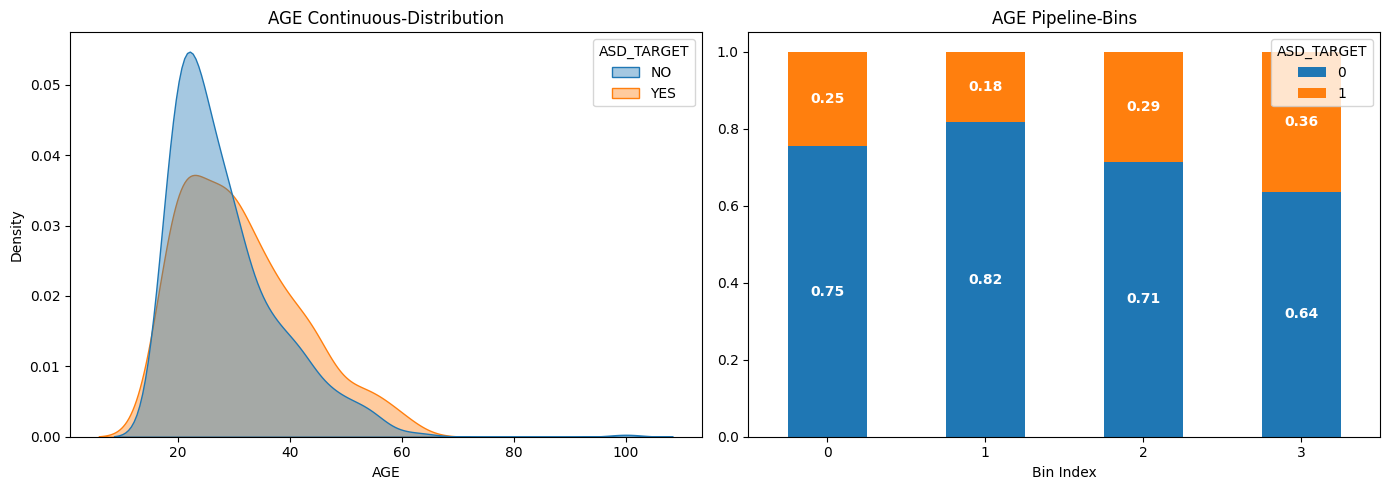

In [13]:
fig_age, axes_age = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=df, x="AGE", hue="ASD_TARGET", fill=True, common_norm=False, alpha=0.4, ax=axes_age[0])
axes_age[0].set_title("AGE Continuous-Distribution")

age_data = df_Bayesian.groupby(["AGE", "ASD_TARGET"]).size().reset_index(name='count')
age_total = age_data.groupby("AGE")["count"].transform("sum")
age_data["proportion"] = age_data["count"] / age_total
age_plot = age_data.pivot(index="AGE", columns="ASD_TARGET", values="proportion").fillna(0)

age_plot.plot(kind="bar", stacked=True, ax=axes_age[1], legend=True)
axes_age[1].set_title("AGE Pipeline-Bins")
axes_age[1].set_xlabel("Bin Index")

axes_age[1].set_xticklabels([int(float(x)) for x in age_plot.index], rotation=0)

for p in axes_age[1].patches:
    if p.get_height() > 0:
        axes_age[1].text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                         f"{p.get_height():.2f}", ha="center", va="center", color="white", fontweight='bold')

plt.tight_layout()
plt.savefig("../_attachments/img/age_analysis.png")
plt.show()

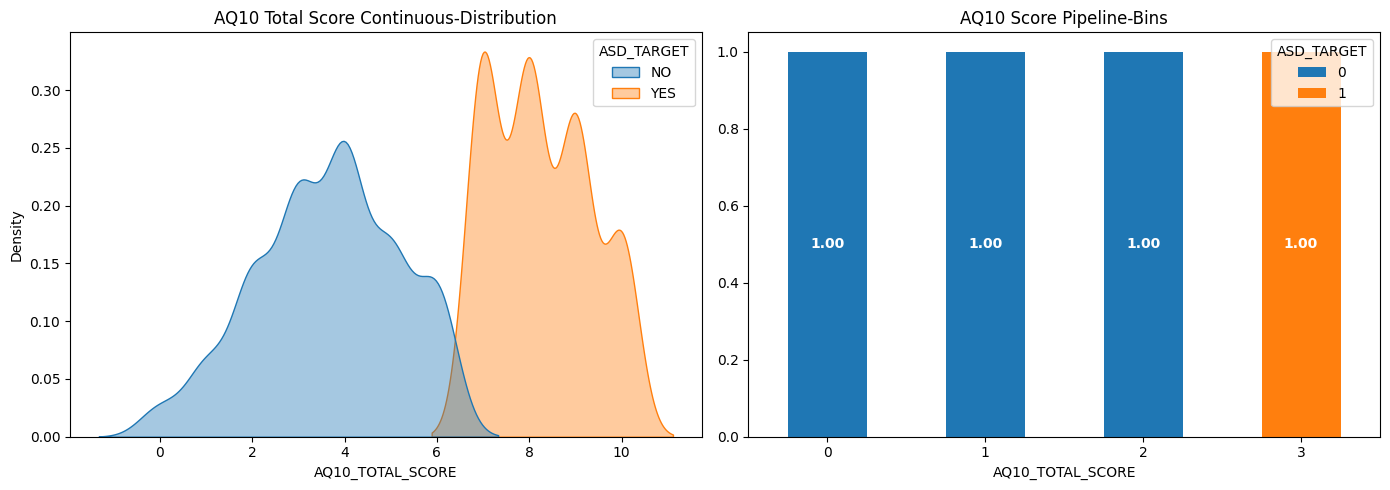

In [14]:
# Gráfico 2: SCORE
fig_score, axes_score = plt.subplots(1, 2, figsize=(14, 5))

sns.kdeplot(data=df, x="AQ10_TOTAL_SCORE", hue="ASD_TARGET", fill=True, common_norm=False, alpha=0.4, ax=axes_score[0])
axes_score[0].set_title("AQ10 Total Score Continuous-Distribution")

score_data = df_Bayesian.groupby(["AQ10_TOTAL_SCORE", "ASD_TARGET"]).size().reset_index(name='count')
score_plot = score_data.pivot(index="AQ10_TOTAL_SCORE", columns="ASD_TARGET", values="count").fillna(0)
score_plot = score_plot.div(score_plot.sum(axis=1), axis=0)

score_plot.plot(kind="bar", stacked=True, ax=axes_score[1], legend=True)
axes_score[1].set_title("AQ10 Score Pipeline-Bins")
axes_score[1].set_xticklabels([int(float(x)) for x in score_plot.index], rotation=0)

for p in axes_score[1].patches:
    if p.get_height() > 0:
        axes_score[1].text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height()/2,
                          f"{p.get_height():.2f}", ha="center", va="center", color="white", fontweight='bold')

plt.tight_layout()
plt.savefig("../_attachments/img/score_analysis.png")
plt.show()


#### **1. Age Variable Analysis**
The transformation of the **AGE** variable through quantile discretization allows for a clearer observation of risk distribution across different life stages:
**Continuous Distribution:** The density plot shows a significant peak in early adulthood (around 20-30 years), where the overlap between ASD and non-ASD cases is most prominent.
**Discretized Bins:** By dividing the age into four strategic bins (0 to 3), we observe that the proportion of ASD positive cases (`ASD_TARGET = 1`) increases slightly in the older bins (Bin 3), suggesting that age remains a relevant conditional factor in the Bayesian Network structure.

#### **2. AQ10 Total Score Analysis**
The **AQ10_TOTAL_SCORE** is the most influential predictor in the dataset, showing a nearly perfect separation of classes:
**Continuous Distribution:** There is a clear "gap" or threshold around a score of 6. Individuals with scores above 6 are almost exclusively classified as ASD positive.
**Discretized Bins:** The pipeline successfully captured this behavior. Bins 0, 1, and 2 show a 100% concentration of negative cases, while Bin 3 contains 100% of the positive cases. This extreme conditional probability confirms that the AQ10 Score will act as a "Hub" or root node with high predictive power in the Bayesian model.

#### **3. Impact on Bayesian Modeling**
The discretization process has successfully converted complex continuous densities into **Conditional Probability Tables (CPTs)** that are computationally efficient. The clear trends observed in both variables ensure that the structural learning algorithms (such as Hill Climbing or PC) will identify strong dependencies, leading to a robust and reliable Bayesian Network.

### <span id="sec53"></span> **5.3 Downloads .CSV y Pipeline**


In [15]:
joblib.dump(bn_pipeline, "../_attachments/pipelines/pipeline_bn.pkl")
joblib.dump(geometric_pipeline, "../_attachments/pipelines/pipeline_gm.pkl")

['../_attachments/pipelines/pipeline_gm.pkl']

In [16]:
df_Bayesian.to_csv("../_attachments/datasets/data-set-bayesian-labels.csv", index=False)
df_geometric.to_csv("../_attachments/datasets/data-set-geometric-labels.csv", index=False)

## <span id="sec6"></span> **6. Correlation analysis**


### <span id="sec61"></span> **6.1 Comparation**

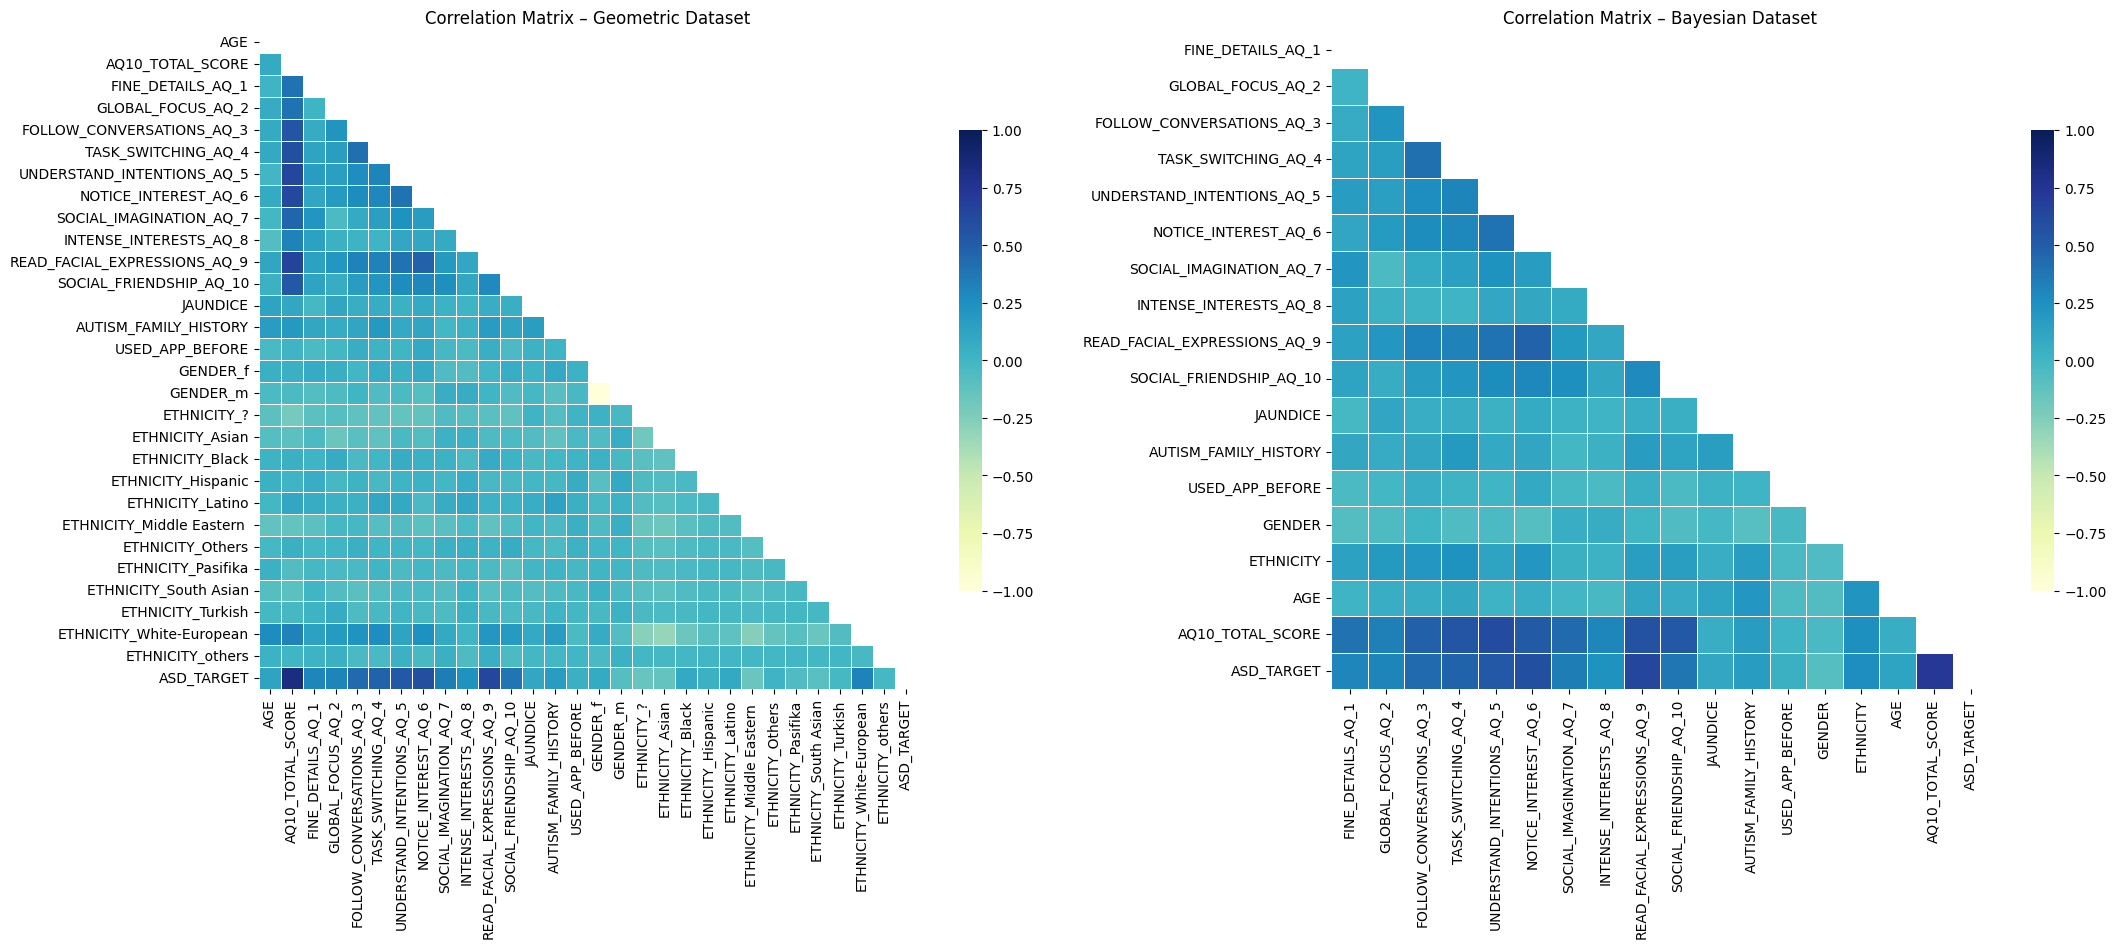

In [17]:
df_geo_corr = df_geometric.copy()
df_bayes_corr = df_Bayesian.copy()

corr_geo = df_geo_corr.corr()
corr_bayes = df_bayes_corr.corr()

mask_geo = np.triu(np.ones_like(corr_geo, dtype=bool))
mask_bayes = np.triu(np.ones_like(corr_bayes, dtype=bool))

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

sns.heatmap(
    corr_geo,
    mask=mask_geo,
    cmap="YlGnBu",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    vmin=-1,
    vmax=1,
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix – Geometric Dataset")
axes[0].tick_params(axis='x', rotation=90)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(
    corr_bayes,
    mask=mask_bayes,
    cmap="YlGnBu",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    vmin=-1,
    vmax=1,
    ax=axes[1]
)
axes[1].set_title("Correlation Matrix – Bayesian Dataset")
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()

plt.savefig(
    "../_attachments/img/correlation_geometric_vs_bayesian.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

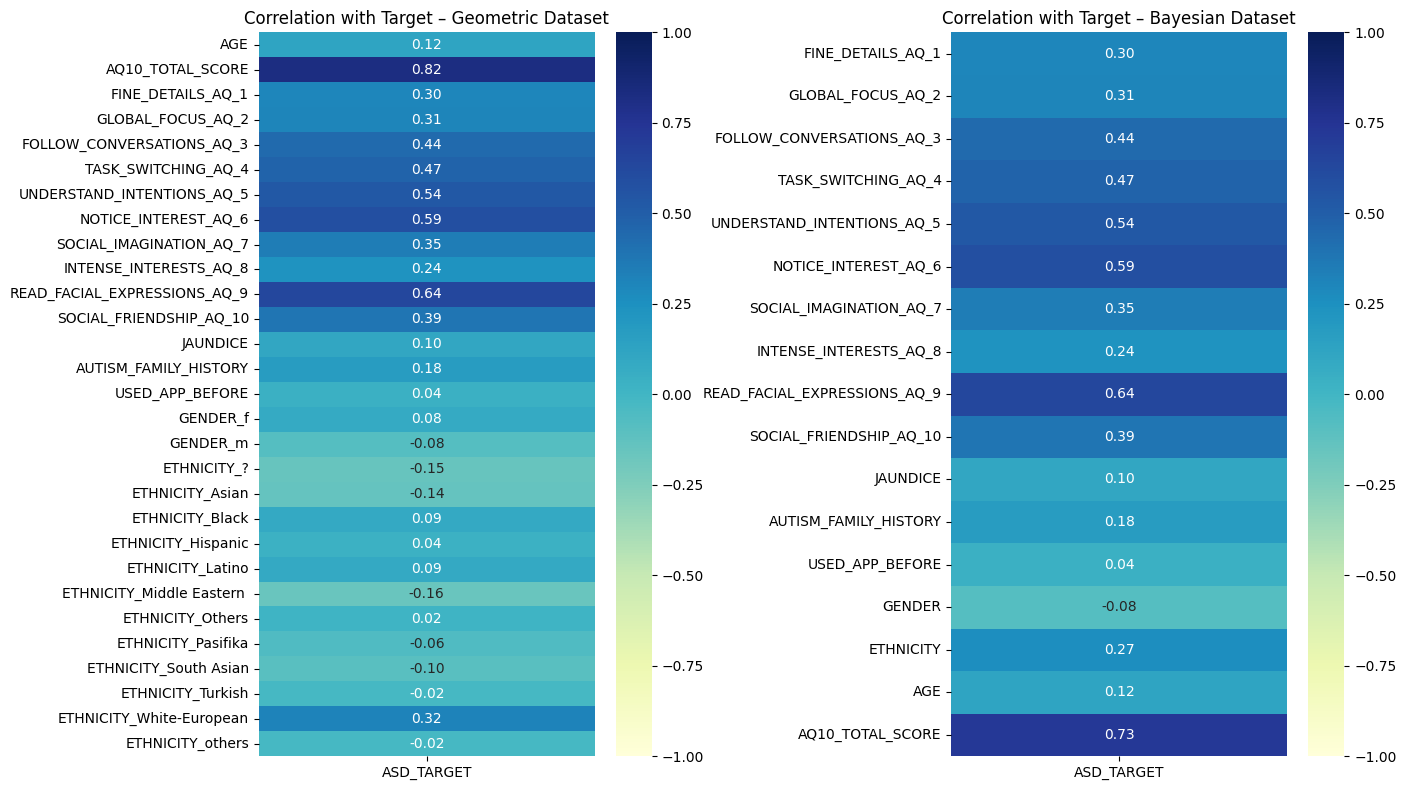

In [18]:
target = "ASD_TARGET"

corr_target_geo = df_geometric.corr()[[target]].drop(index=target)
corr_target_bayes = df_Bayesian.corr()[[target]].drop(index=target)

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=False)

sns.heatmap(
    corr_target_geo,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation with Target – Geometric Dataset")

sns.heatmap(
    corr_target_bayes,
    cmap="YlGnBu",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation with Target – Bayesian Dataset")

plt.tight_layout()

plt.savefig(
    "../_attachments/img/correlation_vs_target_geometric_bayesian.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


### <span id="sec62"></span> **6.2 Results**
Geometric Dataset Correlation Analysis En el conjunto de datos orientado a modelos geométricos, se observa que el AQ10_TOTAL_SCORE es el predictor más robusto con una correlación directa de 0.82 respecto al objetivo ASD_TARGET. Otros factores determinantes incluyen la variable READ_FACIAL_EXPRESSIONS_AQ_9, que registra un valor de 0.64, sugiriendo una fuerte relación lineal entre la percepción social y el diagnóstico. Por otro lado, variables como el género y el historial de ictericia presentan correlaciones mínimas, situándose por debajo del 0.10, lo que indica un impacto estadístico reducido en este enfoque.

Bayesian Dataset Correlation Analysis Para el dataset procesado para la Red Bayesiana, la discretización de variables continuas ajustó la correlación del AQ10_TOTAL_SCORE a 0.73, manteniendo su jerarquía como el nodo principal de influencia. Las variables conductuales (AQ1 a AQ10) muestran una consistencia notable con el dataset original, oscilando entre 0.30 y 0.64, lo que facilita la identificación de dependencias estructurales para el aprendizaje de la red. La baja correlación de variables como USED_APP_BEFORE (0.04) sugiere que estas actúan como nodos independientes o periféricos en el modelo probabilístico.

Comparative and Structural Summary La comparación entre ambos enfoques valida que la transformación de datos no ha degradado la integridad de la información original. Mientras que el modelo geométrico aprovecha la precisión numérica de los puntajes totales, el modelo bayesiano expone relaciones de dependencia entre los rasgos individuales y el objetivo. Este análisis confirma que el dataset está óptimamente preparado para la fase de inferencia y aprendizaje estructural, garantizando tablas de probabilidad condicional bien fundamentadas en las correlaciones observadas.

## <span id="sec7"></span> **7. Conclusions**
Effectiveness of Dual-Branch Transformation The implementation of a dual-branch preprocessing pipeline successfully addressed the distinct requirements of different architectural models. While the geometric branch preserved numerical precision for distance-based algorithms, the Bayesian branch effectively discretized continuous variables like AGE and AQ10_TOTAL_SCORE. This strategy ensured that the inherent data distributions remained consistent across both paradigms, facilitating a fair comparison of model performance.

Predictive Power of AQ10 and Behavioral Features The correlation analysis identified AQ10_TOTAL_SCORE and READ_FACIAL_EXPRESSIONS_AQ_9 as the most significant predictors for ASD detection. The high correlation values (0.82 and 0.64 respectively) suggest that clinical screening scores and social perception traits are fundamental root nodes for any predictive structure. Even after discretization, these features retained their dominance, ensuring robust Conditional Probability Tables (CPTs) for the Bayesian Network.

Data Balance and Structural Integrity The handling of missing data through median and mode imputation, combined with the removal of non-relevant features (such as 'ID' or 'Used_App_Before'), significantly improved the signal-to-noise ratio of the dataset. Furthermore, the transformation of categorical variables into ordinal indices for the Bayesian branch allows for a more efficient structural learning process, as it reduces the complexity of the search space for parent-child relationships within the network.

Modeling Readiness for Inference The final transformed datasets are optimally prepared for the next stage of the machine learning lifecycle. The clear separation of classes observed in the continuous density plots confirms that the chosen bins for discretization are representative of the true underlying risk factors. This foundation is critical for developing a Bayesian model capable of performing accurate probabilistic inference and explaining the causal relationships between autistic traits.